## Wind Turbine Prediction

### Data Processing

In [37]:
from lightgbm import LGBMRegressor
from DataProcessor import DataProcessor
from Trainer import Trainer, get_MAPE, get_SMAPE
from AnomalyDetector import AnomalyDetector
# choose ML model for time series
MODEL =  LGBMRegressor(random_state=42)
PARAM_GRID = {
            'num_leaves': [16, 24, 31],
            'learning_rate': [0.005, 0.01, 0.05],
            'n_estimators': [50, 100, 150],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            }


Turbine = DataProcessor('Turbine1.csv', 'Turbine2.csv')

# Clean and reorder data for Turbine1 and Turbine2
Turbine.df1 = Turbine.clean(Turbine.df1)
Turbine.df2 = Turbine.clean(Turbine.df2)

# Create additional time series features
Turbine.df1 = Turbine.add_features(Turbine.df1)
Turbine.df2 = Turbine.add_features(Turbine.df2)
    
# Combine and aggregate the data
combined_data = Turbine.aggregate()

In [2]:
combined_data.describe()

,Wind,Rotor,Leistung,Azimut,Prod. 1,Prod. 2,Gen1-,Lager,Außen,GetrT,...,KH-DigiE,KH-DigiI,KH-Ana-1,KH-Ana-2,KH-Ana-3,KH-Ana-4,hour,dayofweek,month,week
count,13103.000000,13103.000000,13103.000000,13103.000000,1.310300e+04,1.310300e+04,13103.000000,13103.000000,13103.000000,13103.000000,...,13103.0,13103.0,13103.0,13103.0,13103.0,13103.0,13103.000000,13103.000000,13103.000000,13103.000000
mean,5.764741,12.295299,417.797947,184.129341,3.279745e+07,3.779908e+06,20.840166,55.929497,5.634401,44.506304,...,0.0,0.0,0.0,0.0,0.0,0.0,11.500878,2.999924,2.000076,8.315271
std,2.777249,4.093819,461.042697,83.083597,1.028171e+06,6.246510e+04,16.098335,10.579098,4.202996,6.347428,...,0.0,0.0,0.0,0.0,0.0,0.0,6.921986,2.000134,0.825437,8.982898
min,0.350000,0.000000,-7.400000,0.300000,1.580338e+07,2.875578e+06,0.000000,9.650000,-8.000000,11.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,1.000000
25%,4.000000,10.000000,110.075000,124.550000,3.254457e+07,3.759956e+06,10.000000,50.400000,3.500000,42.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,6.000000,1.000000,1.000000,4.000000
50%,5.500000,13.000000,247.500000,200.250000,3.295947e+07,3.774422e+06,17.700000,56.650000,6.000000,44.950000,...,0.0,0.0,0.0,0.0,0.0,0.0,12.000000,3.000000,2.000000,7.000000
75%,7.075000,16.000000,553.525000,241.650000,3.307950e+07,3.810814e+06,25.575000,63.950000,8.450000,47.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,17.500000,5.000000,3.000000,10.000000
max,17.850000,16.000000,2118.950000,359.550000,3.320206e+07,3.844990e+06,83.700000,75.000000,17.950000,60.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,23.000000,6.000000,3.000000,53.000000


### Prediction

### One Feature

In [38]:

# initiate Trainer class
trainer = Trainer(combined_data)
# Auto feature selection
trainer.features = ["Wind"]  

# Split data into train and test sets
x_train, x_test, y_train, y_test = trainer.data_splitter()
# fine tune via GridSearch
# MODEL = trainer.tune(PARAM_GRID, MODEL, x_train, y_train)
# # Train and evaluate the model
lgb_model, MAE_scores = trainer.train(MODEL, x_train, y_train)
sampe, mape, mae = trainer.evaluate(lgb_model, x_test, y_test)
print('cross validated MAE: %.3f ' % (MAE_scores.mean()))
print('-' * 50)
print("Test set MAPE:", mape)
print("Test set SMAPE:", sampe)
print("Test set MAE:", mae)
    


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 10482, number of used features: 1
[LightGBM] [Info] Start training from score 444.713280
cross validated MAE: 30.749 
--------------------------------------------------
Test set MAPE: 3.442851448511671
Test set SMAPE: 0.30933055946116356
Test set MAE: 27.995101200373472


### Multi-Features

In [4]:

# initiate Trainer class
trainer = Trainer(combined_data)
# Auto feature selection
trainer.features = trainer.select_features(n= 12) #Or set it manually e.g: ["Wind"]   

# Split data into train and test sets
x_train, x_test, y_train, y_test = trainer.data_splitter()
# fine tune via GridSearch
tuned_model = trainer.tune(PARAM_GRID, MODEL, x_train, y_train)
 


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2964
[LightGBM] [Info] Number of data points in the train set: 10482, number of used features: 12
[LightGBM] [Info] Start training from score 444.713280


In [5]:
tuned_model

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=150,
              random_state=42, subsample=0.8)

In [6]:
# Train and evaluate the model
lgb_model, MAE_scores = trainer.train(MODEL, x_train, y_train)
sampe, mape, mae = trainer.evaluate(lgb_model, x_test, y_test)
print('cross validated MAE: %.3f ' % (MAE_scores.mean()))
print('-' * 50)
print("Test set MAPE:", mape)
print("Test set SMAPE:", sampe)
print("Test set MAE:", mae)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2964
[LightGBM] [Info] Number of data points in the train set: 10482, number of used features: 12
[LightGBM] [Info] Start training from score 444.713280
cross validated MAE: 7.913 
--------------------------------------------------
Test set MAPE: 0.2291028562043878
Test set SMAPE: 0.1711896467697045
Test set MAE: 4.787762103651617


## Anomaly Detection 

In [31]:
from AnomalyDetector import AnomalyDetector

# Instantiate AnomalyDetector
anomaly_detector = AnomalyDetector(Turbine.df1) #combined_data
# Fit the Isolation Forest model
anomaly_detector.fit_model()
# Detect anomalies
anomaly_table = anomaly_detector.detect_anomalies()

X does not have valid feature names, but IsolationForest was fitted with feature names


In [10]:
anomaly_detector.data[['Wind', 'anomaly']][anomaly_detector.data['anomaly']==-1].head()

,Wind,anomaly
Dat/Zeit,,
2016-01-01 00:10:00,5.8,-1
2016-01-01 00:20:00,5.8,-1
2016-01-01 00:30:00,5.8,-1
2016-01-01 00:40:00,6.4,-1
2016-01-01 00:50:00,6.9,-1


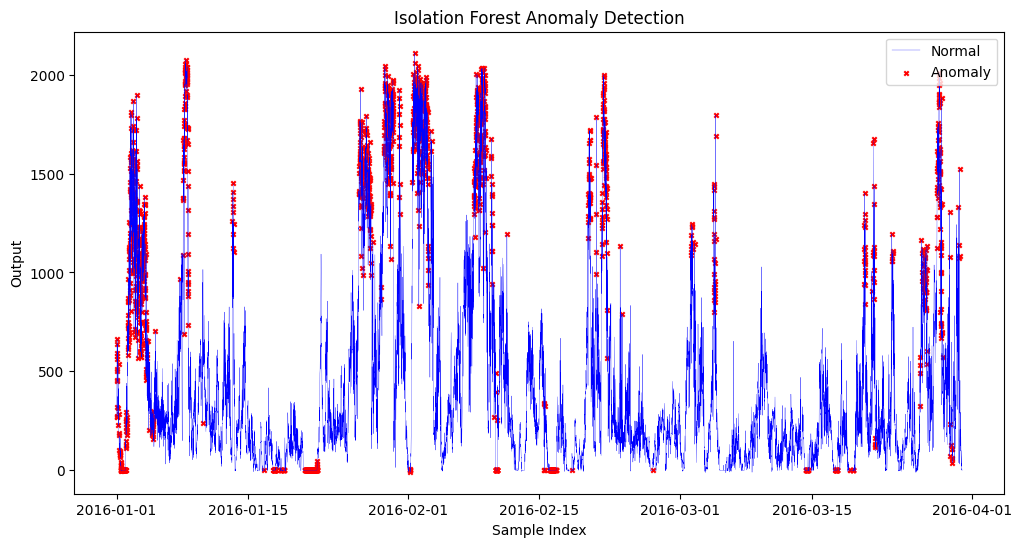

In [114]:
# Visualize anomalies
anomaly_detector.visualize_anomalies(until_date= '2016-3-31')

## t-SNE Feature Visualization

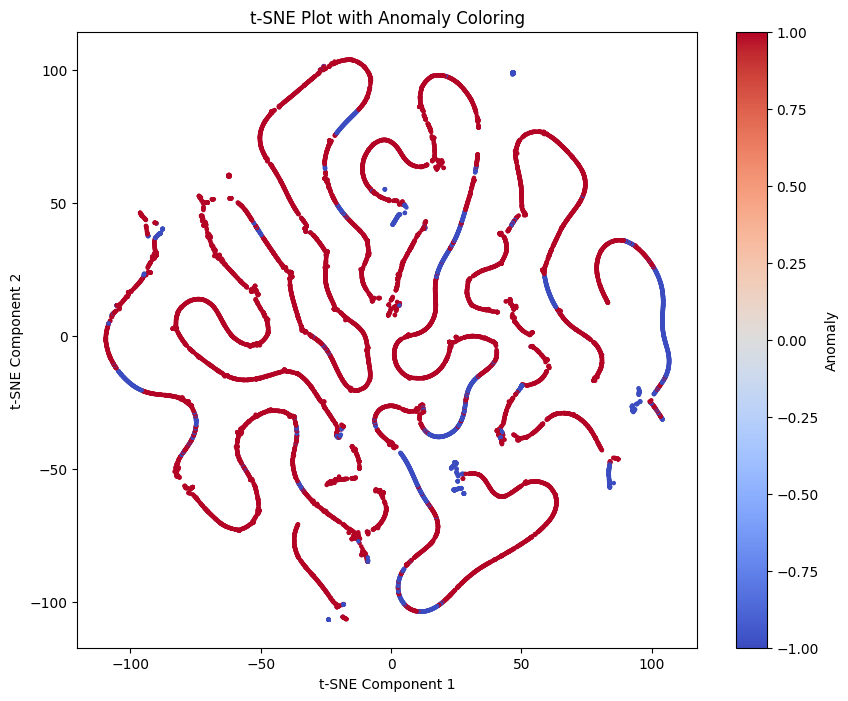

In [39]:
# show t-SNE
anomaly_detector.visualize_tsne()